In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import  numpy as np
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle

df_tracks = pd.read_csv('MyData/output/tracks_metal.csv')
df_tracks = df_tracks.dropna().drop(["key", "time_signature"], axis=1)
df_tracks = df_tracks[df_tracks["count"] > 1] 
df_tracks = df_tracks[df_tracks["liveness"] < 0.7] #remove tracks with a high chance of being live
df_tracks = df_tracks[df_tracks["speechiness"] < 0.66] #remove speech-like record, intro

df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 7 to 779
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artistName        312 non-null    object 
 1   trackName         312 non-null    object 
 2   sPlayed           312 non-null    int64  
 3   count             312 non-null    int64  
 4   genres            312 non-null    object 
 5   trackId           312 non-null    object 
 6   duration          312 non-null    float64
 7   danceability      312 non-null    float64
 8   acousticness      312 non-null    float64
 9   energy            312 non-null    float64
 10  instrumentalness  312 non-null    float64
 11  liveness          312 non-null    float64
 12  valence           312 non-null    float64
 13  loudness          312 non-null    float64
 14  speechiness       312 non-null    float64
 15  tempo             312 non-null    float64
dtypes: float64(10), int64(2), object(4)
memory u

Features (9): danceability, acousticness, energy, instrumentalness, liveness,   valence, loudness, speechiness, tempo

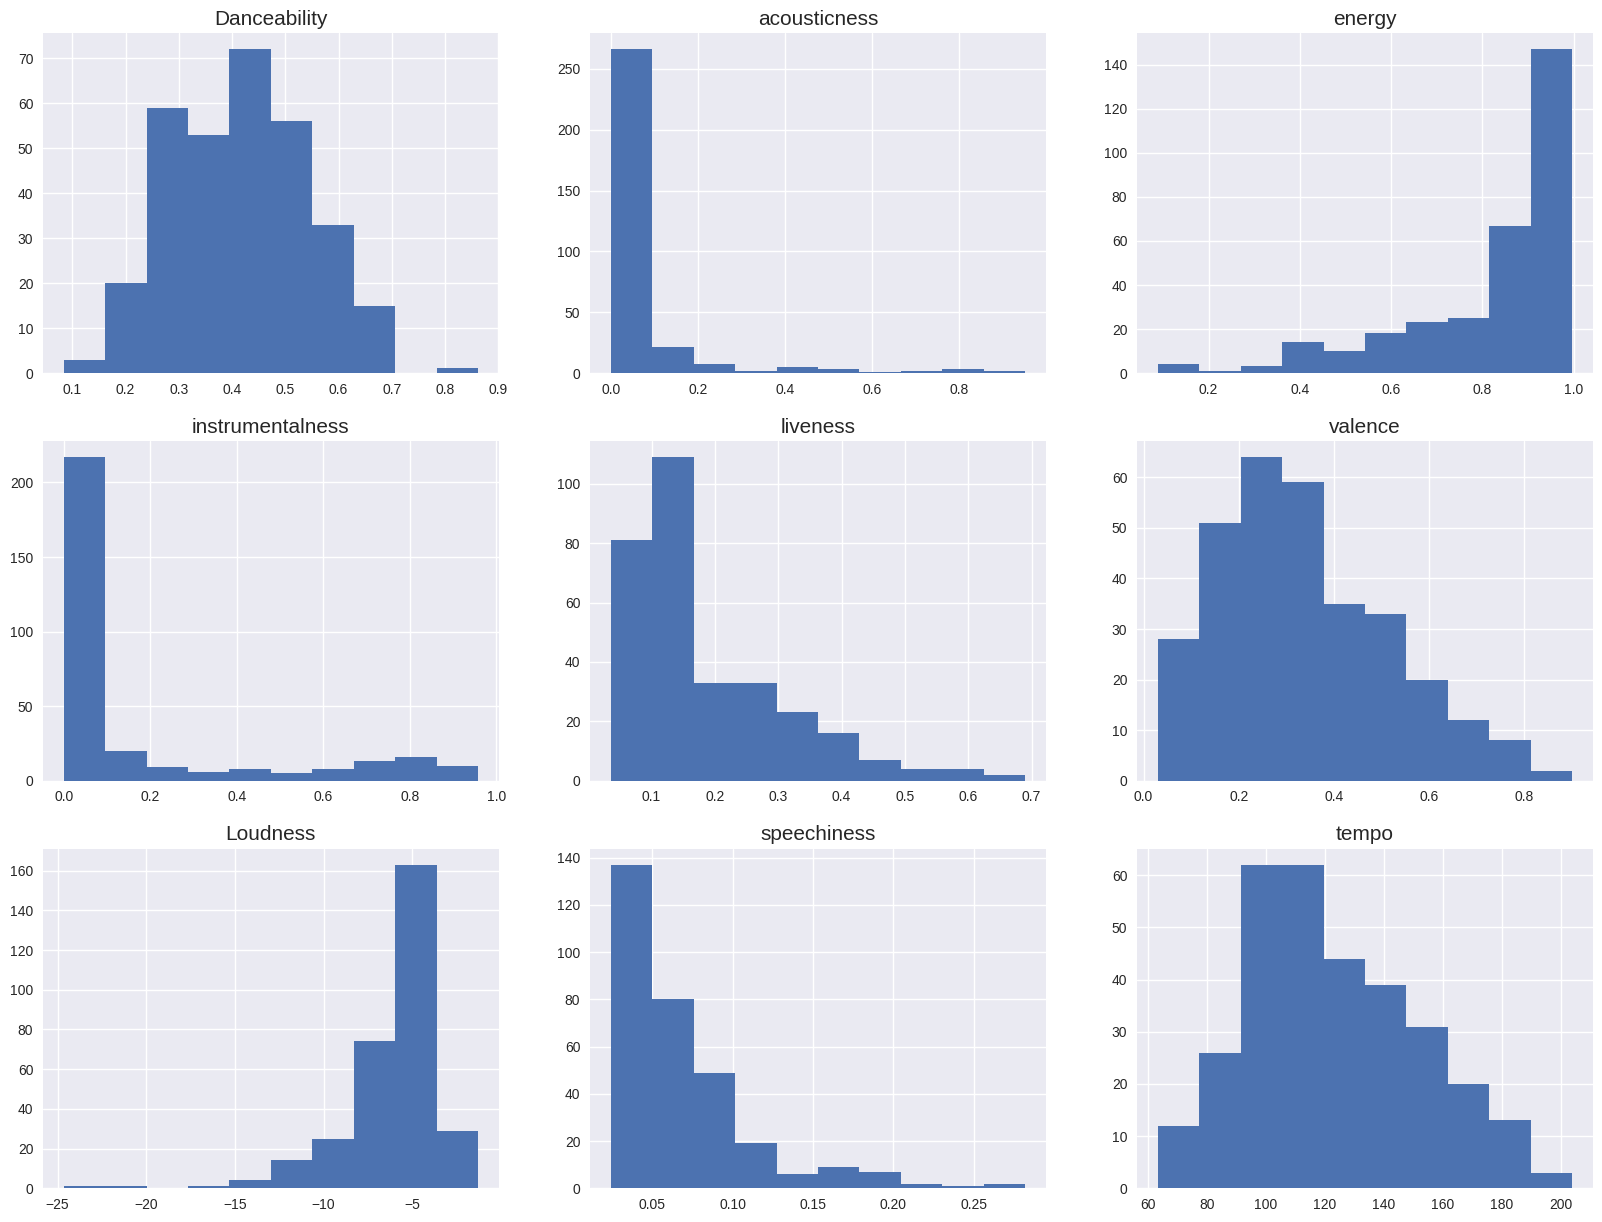

In [2]:
fig,axes = plt.subplots(3,3,figsize=(20,15))

axes[0,0].hist(df_tracks['danceability'])
axes[0,0].set_title('Danceability',fontsize=15)
axes[0,1].hist(df_tracks['acousticness'])
axes[0,1].set_title('acousticness',fontsize=15)
axes[0,2].hist(df_tracks['energy'])
axes[0,2].set_title('energy',fontsize=15)
axes[1,0].hist(df_tracks['instrumentalness'])
axes[1,0].set_title('instrumentalness',fontsize=15)
axes[1,1].hist(df_tracks['liveness'])
axes[1,1].set_title('liveness',fontsize=15)
axes[1,2].hist(df_tracks['valence'])
axes[1,2].set_title('valence',fontsize=15)
axes[2,0].hist(df_tracks['loudness'])
axes[2,0].set_title('Loudness',fontsize=15)
axes[2,1].hist(df_tracks['speechiness'])
axes[2,1].set_title('speechiness',fontsize=15)
axes[2,2].hist(df_tracks['tempo'])
axes[2,2].set_title('tempo',fontsize=15)
plt.show()

In [3]:
df_pca = df_tracks[["danceability", "energy",  "speechiness", "valence", "loudness","acousticness", "instrumentalness", "tempo"]].dropna()
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_features = scaler.fit_transform(df_pca)

pca = decomposition.PCA(n_components=2)
pca.fit(scaled_features)
print(pca.components_)
print(pca.explained_variance_)

[[ 0.11043046 -0.55645834 -0.33206887 -0.11093907 -0.52246255  0.48312903
   0.05842312 -0.21398126]
 [-0.63111165 -0.05302017  0.35074899 -0.58721818 -0.09134906  0.13262073
   0.2759706   0.17012999]]
[2.7438917  1.47152603]


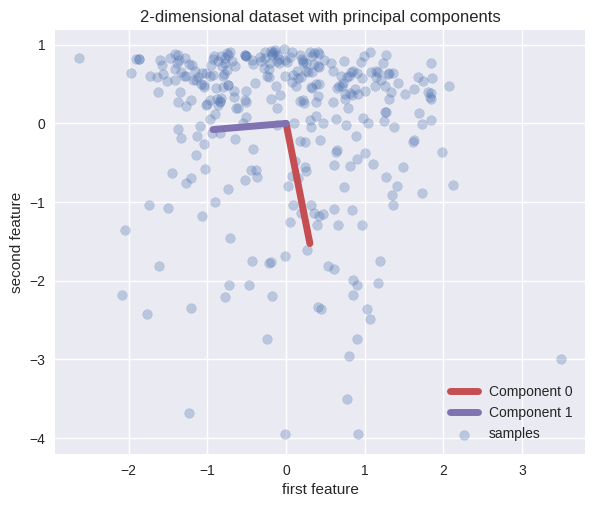

In [4]:
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], alpha=.3, label='samples')
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

y = scaled_features.dot(pca.components_[1]) 

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(scaled_features.dot(pca.components_[0]), y, alpha=.3)
axes[0].set(xlabel='Projected data onto first PCA component', ylabel='y')
axes[1].scatter(scaled_features.dot(pca.components_[1]), y, alpha=.3)
axes[1].set(xlabel='Projected data onto second PCA component', ylabel='y')
plt.tight_layout()
plt.show()

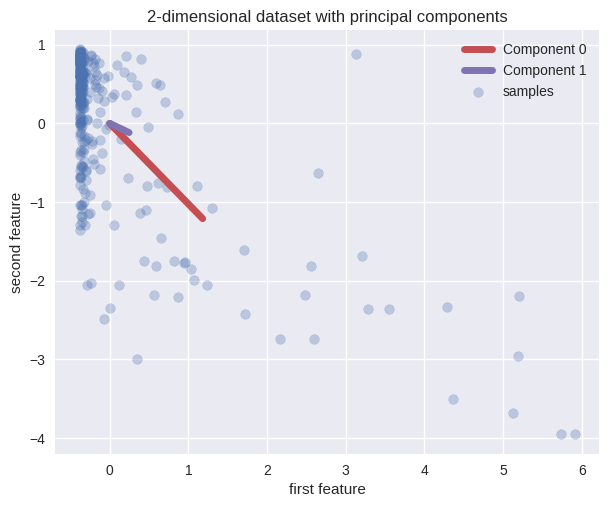

In [5]:
features = df_tracks[["acousticness", "energy", "valence"]].dropna()
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_features = scaler.fit_transform(features)

pca = decomposition.PCA(n_components=2)
pca.fit(scaled_features)

plt.scatter(scaled_features[:, 0], scaled_features[:, 1], alpha=.3, label='samples')
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

In [6]:
# k-means with centered featuress
scaler = StandardScaler(with_mean=True, with_std=False)
centered_features = scaler.fit_transform(features)
kmeans = KMeans(init="k-means++",n_clusters=2,random_state=15).fit(centered_features)
df_tracks['kmeans'] = kmeans.labels_


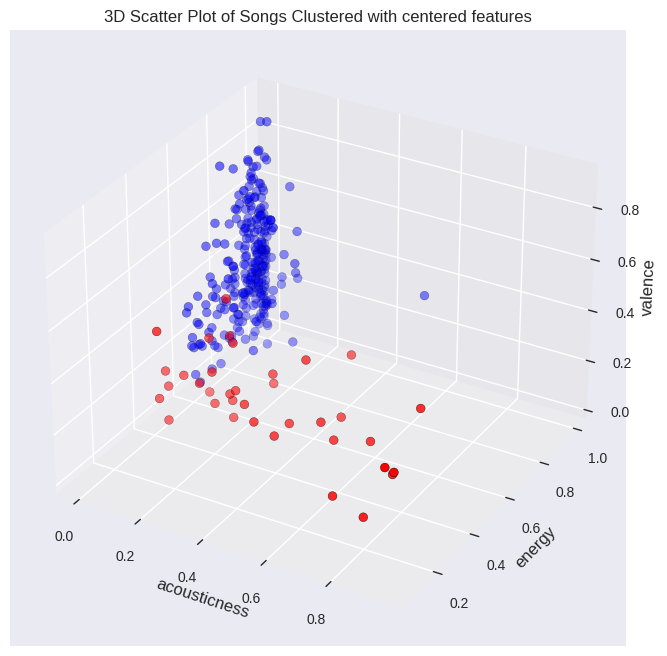

In [7]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

x = df_tracks['acousticness']
y = df_tracks['energy']
z = df_tracks['valence']
cmhot = cmhot = plt.get_cmap('bwr')

ax.scatter(x,y,z,c=df_tracks['kmeans'],s=40,cmap=cmhot, edgecolor="black")
ax.set_xlabel('acousticness',fontsize=12)
ax.set_ylabel('energy',fontsize=12)
ax.set_zlabel('valence',fontsize=12)
ax.set_title("3D Scatter Plot of Songs Clustered with centered features")
plt.show()

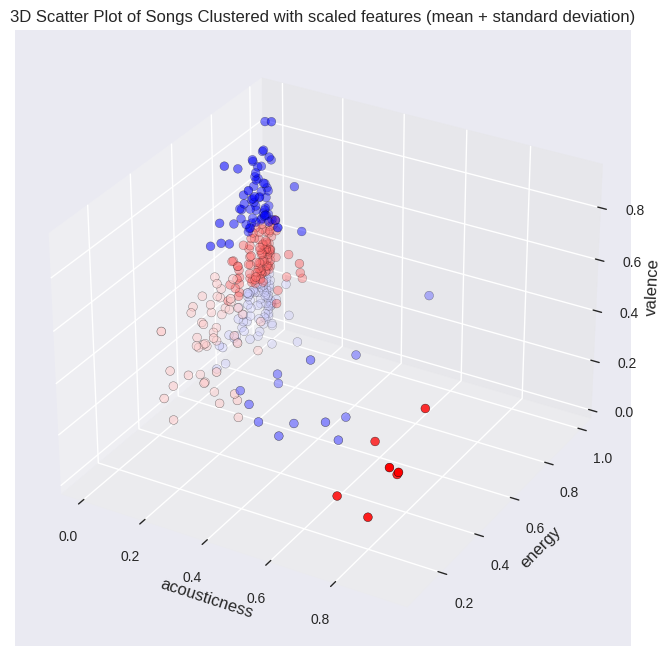

In [14]:
# k-means with scaled featuress
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_features = scaler.fit_transform(features)
kmeans = KMeans(init="k-means++",n_clusters=6,random_state=15).fit(scaled_features)
df_tracks['kmeans'] = kmeans.labels_
fig = plt.figure(figsize=(10,8)
                )
ax = fig.add_subplot(111,projection='3d')

x = df_tracks['acousticness']
y = df_tracks['energy']
z = df_tracks['valence']
cmhot = cmhot = plt.get_cmap('bwr')

ax.scatter(x,y,z,c=df_tracks['kmeans'],s=40,cmap=cmhot, edgecolor="black")
ax.set_xlabel('acousticness',fontsize=12)
ax.set_ylabel('energy',fontsize=12)
ax.set_zlabel('valence',fontsize=12)
ax.set_title("3D Scatter Plot of Songs Clustered with scaled features (mean + standard deviation)")
plt.show()

In [16]:
for i in range(6):
    print(i, len(df_tracks[df_tracks['kmeans'] == i].index))

df_tracks.groupby(['kmeans']).mean()

0 66
1 13
2 76
3 49
4 101
5 7


,sPlayed,count,duration,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo
kmeans,,,,,,,,,,,,
0,1475.848485,6.378788,271742.818182,0.465273,0.018869,0.889379,0.115606,0.186689,0.613242,-5.400909,0.058709,127.014758
1,788.076923,3.923077,265440.000000,0.377077,0.425462,0.497462,0.186538,0.156846,0.226462,-10.218000,0.038931,100.599308
2,2063.486842,6.078947,349951.842105,0.385999,0.009544,0.906368,0.253953,0.209275,0.156530,-5.394908,0.084399,120.965079
3,1110.183673,4.224490,321455.020408,0.440367,0.062430,0.584816,0.185710,0.126763,0.256069,-7.945367,0.038739,122.026102
4,1271.366337,4.920792,304164.970297,0.403980,0.015410,0.914683,0.121275,0.198665,0.355604,-5.212970,0.082784,126.776743
5,2367.285714,14.142857,281033.571429,0.445000,0.832286,0.224486,0.234932,0.155343,0.277571,-14.807857,0.038529,93.890571


In [10]:
#cluster_0 = df_tracks[df_tracks['kmeans']==0]
#cluster_1 = df_tracks[df_tracks['kmeans']==1]
#cluster_2 = df_tracks[df_tracks['kmeans']==2]
#cluster_3 = df_tracks[df_tracks['kmeans']==3]

#cluster_0.to_csv("MyData/output/cluster0.csv",index=False)
#cluster_1.to_csv("MyData/output/cluster1.csv",index=False)
#cluster_2.to_csv("MyData/output/cluster2.csv",index=False)
#cluster_3.to_csv("MyData/output/cluster3.csv",index=False)

#df_tracks.to_csv("MyData/output//tracks_cluster.csv",index=False)

In [11]:
bandwidth = estimate_bandwidth(scaled_features, quantile=0.25)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(scaled_features)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


number of estimated clusters : 5


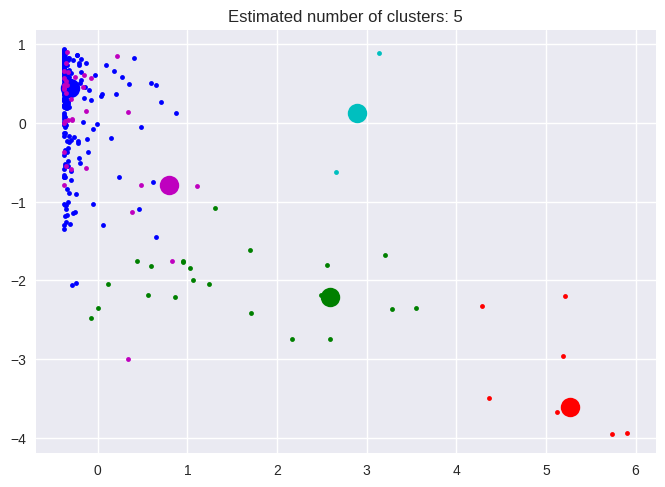

In [12]:
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(scaled_features[my_members, 0], scaled_features[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()